In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report



In [3]:
from google.colab import files
uploaded = files.upload()  # Upload your dataset.zip file

Saving archive (4).zip to archive (4).zip


In [4]:
with zipfile.ZipFile('archive (4).zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [5]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Use the correctly defined train_dir
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, # Use the correctly defined train_dir
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

model.summary()  # Verify parameter count (~400K)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to save time
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Train for 20 epochs (often stops early)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 223ms/step - accuracy: 0.2492 - loss: 2.0475 - val_accuracy: 0.2526 - val_loss: 1.8346 - learning_rate: 0.0010
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.3611 - loss: 1.6266 - val_accuracy: 0.2439 - val_loss: 1.9273 - learning_rate: 0.0010
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 233ms/step - accuracy: 0.3861 - loss: 1.5611 - val_accuracy: 0.3858 - val_loss: 1.5737 - learning_rate: 0.0010
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 222ms/step - accuracy: 0.4254 - loss: 1.4751 - val_accuracy: 0.2416 - val_loss: 1.8901 - learning_rate: 0.0010
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.4379 - loss: 1.4331 - val_accuracy: 0.4241 - val_loss: 1.4702 - learning_rate: 0.0010
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.4599 - loss: 1.3885 - val_accuracy: 0.3951 - val_loss: 1.5201 - learning_rate: 0.0010
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.4

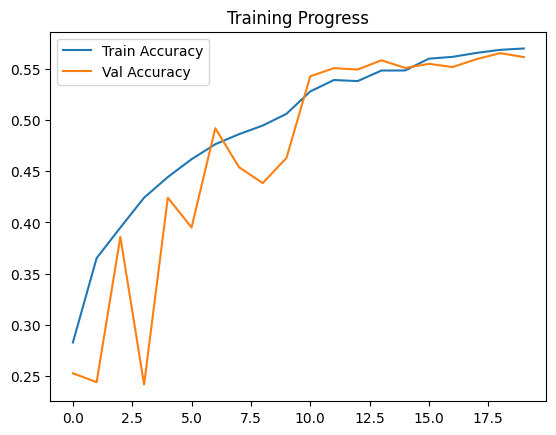

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


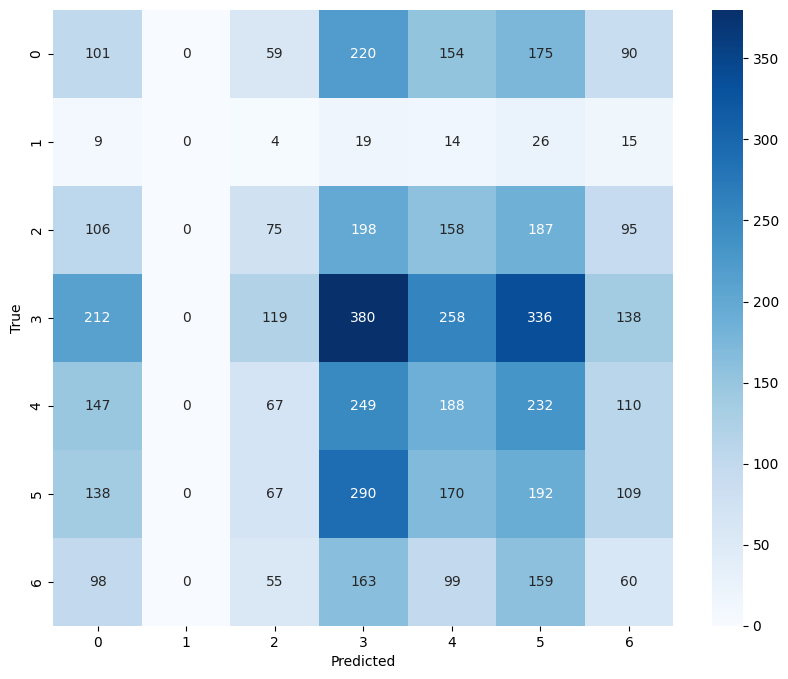

              precision    recall  f1-score   support

       angry       0.12      0.13      0.13       799
     disgust       0.00      0.00      0.00        87
        fear       0.17      0.09      0.12       819
       happy       0.25      0.26      0.26      1443
     neutral       0.18      0.19      0.18       993
         sad       0.15      0.20      0.17       966
    surprise       0.10      0.09      0.10       634

    accuracy                           0.17      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.17      0.17      5741



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training Progress')
plt.legend()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
# Get the class names from the generator's class_indices attribute
class_names = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_names))